# Tarea ML reto clase 1

## Importamos librerias

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# BU

Queremos saber e intentar predecir la calidad de sueño de las personas dada informacion dada por persona.

## Leemos los datos y checamos las primeras 5 filas

In [2]:
data = pd.read_csv('synthetic_coffee_health_10000.csv', index_col=0)
data.head()

,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
ID,,,,,,,,,,,,,,,
1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


## Informacion importante de los datos

Vemos que los unicos datos faltantes estan en Health_Issues y los rellenamos con "No"

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      10000 non-null  int64  
 1   Gender                   10000 non-null  object 
 2   Country                  10000 non-null  object 
 3   Coffee_Intake            10000 non-null  float64
 4   Caffeine_mg              10000 non-null  float64
 5   Sleep_Hours              10000 non-null  float64
 6   Sleep_Quality            10000 non-null  object 
 7   BMI                      10000 non-null  float64
 8   Heart_Rate               10000 non-null  int64  
 9   Stress_Level             10000 non-null  object 
 10  Physical_Activity_Hours  10000 non-null  float64
 11  Health_Issues            4059 non-null   object 
 12  Occupation               10000 non-null  object 
 13  Smoking                  10000 non-null  int64  
 14  Alcohol_Consumption      10

In [4]:
data['Health_Issues'].fillna('No', inplace=True)

C:\Users\KALED\AppData\Local\Temp\ipykernel_26200\1325122684.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Health_Issues'].fillna('No', inplace=True)


In [5]:
data['Health_Issues'].value_counts()

Health_Issues
No          5941
Mild        3579
Moderate     463
Severe        17
Name: count, dtype: int64

## Separacion de los datos
### Transformamos la variable "y" a ordinal

In [6]:
X = data.drop('Sleep_Quality', axis=1)
y = data['Sleep_Quality']
le = LabelEncoder()
y = le.fit_transform(data['Sleep_Quality'])

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42)

## Generamos nuestro preprocesador de los datos

In [7]:
cat_ordinal_cols = ['Stress_Level']
cat_onehot_cols = ['Gender', 'Country', 'Occupation']
num_cols = data.select_dtypes(include=['number']).columns

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ord_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('power', PowerTransformer(method='yeo-johnson'))
])

pre = ColumnTransformer(
    transformers=[
        ('cat_ordinal', ord_pipe, cat_ordinal_cols),
        ('cat_onehot', cat_pipe, cat_onehot_cols),
        ('num', num_pipe, num_cols)
    ]
)


## Iniciamos nuestro pipeline con XGBoostClassifier

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe = Pipeline(steps=[
    ('pre', pre),
    ('model', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42
    ))
])

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 4, 5],
    'model__learning_rate': [0.1, 0.05, 0.01],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


## Feature Importance

In [ ]:
xgb_final = best_model.named_steps["model"]
importances = xgb_final.feature_importances_
feature_names = best_model.named_steps["pre"].get_feature_names_out()
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)
feat_imp.head(15)

,Feature,Importance
0,cat_ordinal__Stress_Level,0.546572
32,num__Sleep_Hours,0.411018
21,cat_onehot__Country_Switzerland,0.002908
7,cat_onehot__Country_Canada,0.002568
31,num__Caffeine_mg,0.002534
30,num__Coffee_Intake,0.001954
8,cat_onehot__Country_China,0.001754
24,cat_onehot__Occupation_Healthcare,0.001714
34,num__Heart_Rate,0.001647
1,cat_onehot__Gender_Female,0.001505


<Figure size 1000x600 with 0 Axes>

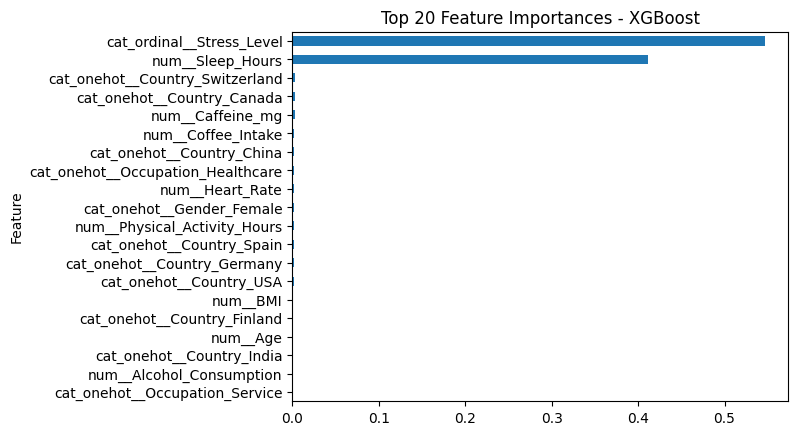

In [ ]:
plt.figure(figsize=(10,6))
feat_imp.head(20).plot(kind="barh", x="Feature", y="Importance", legend=False)
plt.title("Top 20 Feature Importances - XGBoost")
plt.gca().invert_yaxis()
plt.show()

## Vemos los resultados XGBoost

In [ ]:
print("Mapeo de Clases:")
print(le.classes_)
print(np.unique(y), end='\n\n')
print('=======================================================')
print("Accuracy Score!:", accuracy_score(y_test, y_pred))
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score!:", f1)
print(classification_report(y_test, y_pred))
print('=======================================================')

Mapeo de Clases:
['Excellent' 'Fair' 'Good' 'Poor']
[0 1 2 3]

Accuracy Score!: 0.99
F1 Score!: 0.989985916873198
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       273
           1       1.00      1.00      1.00       375
           2       0.99      0.99      0.99      1162
           3       1.00      1.00      1.00       190

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



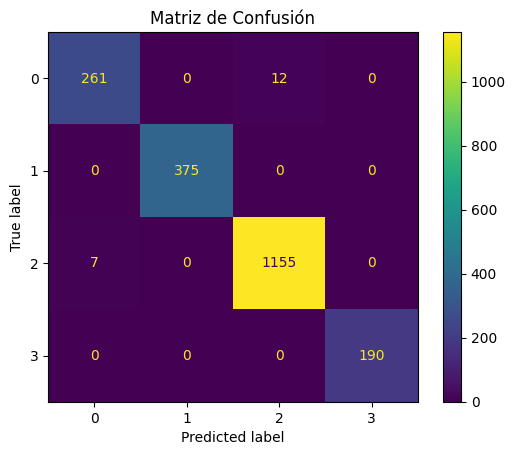

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Matriz de Confusión')
plt.show()

## Implementación del pipeline CatBoostClassifier

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cat_pipe = Pipeline(steps=[
    ('pre', pre),
    ('model', CatBoostClassifier(
        loss_function='MultiClass',
        random_state=42,
        verbose=0
    ))
])

cat_param_grid = {
    'model__iterations': [200, 400],
    'model__depth': [3, 4, 5],
    'model__learning_rate': [0.1, 0.05, 0.01],
    'model__l2_leaf_reg': [1, 3, 5]
}

cat_grid_search = GridSearchCV(cat_pipe, cat_param_grid, cv=cv, n_jobs=-1, verbose=1)
cat_grid_search.fit(X_train, y_train)

cat_best_model = cat_grid_search.best_estimator_
cat_y_pred = cat_best_model.predict(X_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


## Feature Importance

In [18]:
# Feature importance for CatBoost
cat_final = cat_best_model.named_steps["model"]
cat_importances = cat_final.feature_importances_
cat_feature_names = cat_best_model.named_steps["pre"].get_feature_names_out()
cat_feat_imp = pd.DataFrame({
    "Feature": cat_feature_names,
    "Importance": cat_importances
}).sort_values(by="Importance", ascending=False)
cat_feat_imp.head(15)

,Feature,Importance
0,cat_ordinal__Stress_Level,49.373171
32,num__Sleep_Hours,47.193861
34,num__Heart_Rate,0.588307
35,num__Physical_Activity_Hours,0.458784
29,num__Age,0.417314
33,num__BMI,0.364765
31,num__Caffeine_mg,0.328247
30,num__Coffee_Intake,0.218018
24,cat_onehot__Occupation_Healthcare,0.109143
1,cat_onehot__Gender_Female,0.105124


<Figure size 1000x600 with 0 Axes>

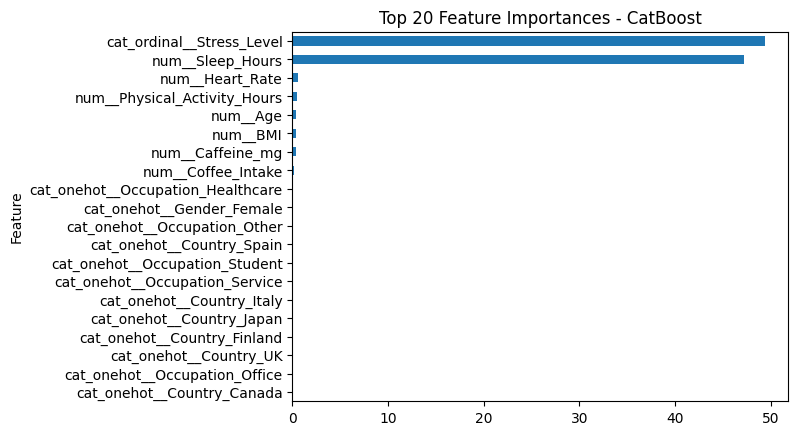

In [19]:
plt.figure(figsize=(10,6))
cat_feat_imp.head(20).plot(kind="barh", x="Feature", y="Importance", legend=False)
plt.title("Top 20 Feature Importances - CatBoost")
plt.gca().invert_yaxis()
plt.show()

## Vemos los resultados CatBoost

Mapeo de Clases:
['Excellent' 'Fair' 'Good' 'Poor']
[0 1 2 3]

Accuracy Score!: 0.99
F1 Score!: 0.989985916873198
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       273
           1       1.00      1.00      1.00       375
           2       0.99      0.99      0.99      1162
           3       1.00      1.00      1.00       190

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



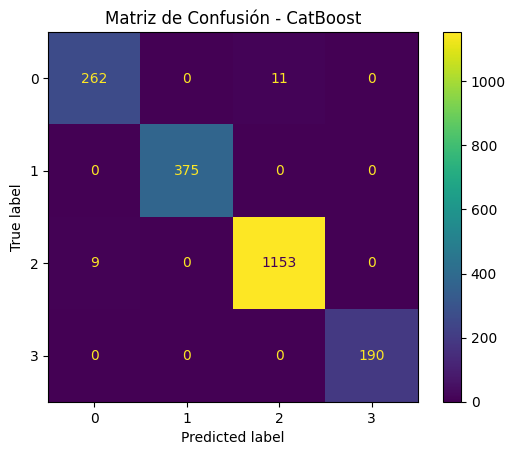

In [20]:
print("Mapeo de Clases:")
print(le.classes_)
print(np.unique(y), end='\n\n')
print('=======================================================')
print("Accuracy Score!:", accuracy_score(y_test, cat_y_pred))
cat_f1 = f1_score(y_test, cat_y_pred, average='weighted')
print("F1 Score!:", cat_f1)
print(classification_report(y_test, cat_y_pred))
print('=======================================================')

ConfusionMatrixDisplay.from_estimator(cat_best_model, X_test, y_test)
plt.title('Matriz de Confusión - CatBoost')
plt.show()